In [1392]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc

In [1558]:
import copy
import _pickle as pickle

# Table of Contents

* 1. MDP Tuple creation for each of the 3 questions.
    * 1.1. World 1
        * Code for Q1. MDP
    * 1.2. World 2 (with bonus)
        * Code for Q2. MDP with bonus
    * 1.3. World 3
        * Code for Q3. MDP
* 2. Solutions
    * Q1. a: Environment Simulator (Q1. a)
    * Q1. b: Agents (Q1. b)
        * b.1. Value Iteration
        * b.2. Policy Iteration
        * b.3. Confused Agent
    * Q1. c: Simulations
        * Running the simulations and plotting.
        * Value function and Policy plots for Value iteration.
        * Value function and Policy plots for Policy iteration.
    * Q2. a: Explanation and Policy iteration equations
    * Q2. b: Reproduction of graphs
    * Q2. c: Bonus: Policy Visualisation
    * Q3. a: Explanation and Value iteration equations
    * Q2. b: Reproduction of fraphs
    * Q3. c: Bonus: Theta convergence visualisation

# 1. MDP Tuple (S, A, R, P, is_term) creation

* S: set of states.
* A: set of actions.
* P: P(s, a, s'): Transition probabilities.
* R: R(s, a, s'): Rewards
* is_term: function which takes in a state and returns `True` if it is terminal else `False`.

Transition probabilities and rewards are stored using dictionaries as shown to ease computations:

$
P[(s, a)] = \{s_1: P(s, a, s_1), s_2: P(s, a, s_2) ...\} \\
R[(s, a)] = \{s_1: R(s, a, s_1), s_2: R(s, a, s_2) ...\}
$

In case multiple rewards are possible for given s, a, s', they are weighted averages based on their corresponding probabilities.

This notation is consistent in all MDPs created.

## 1.1. World 1

### World design: 

The world is a 8x8 grid with possible actions: left (l), right (r), up (u), down (d). The player can move in the desired direction with a probability of 0.7 and randomly in any other direction with probability of 0.1. 

The player gets a reward of:
* -1: if next_state is not current_state and next_state is not terminal_state
* -2: if next_state is current_state
* -10: if state == (7, 0)
* 10: if state == (0, 7)
* 20: if state == (7, 7)

The world size is a variable which can be set in the box below.

In [1801]:
size=8

### Defining States and Actions

In [1825]:
S = [[(j, i) for i in range(0, size)] for j in range(0, size)]
A = (['l', 'r', 'u', 'd'])
term_rewards = {(0, size-1): 10, (size-1, 0): -10, (size-1, size-1): 40}

In [1826]:
def is_term(s):
    if s in {(0, size-1): 10, (size-1, 0): -10, (size-1, size-1): 40}:
        return True
    return False

In [1827]:
def deterministic(action, state_):
    """ Returns next_state, reward, is_terminated """
    state = [state_[0], state_[1]]
    if action == 'l' and not state[1] == 0: state[1] = state[1] - 1
    if action == 'r' and not state[1] == size-1: state[1] = state[1] + 1
    if action == 'u' and not state[0] == 0: state[0] = state[0] - 1
    if action == 'd' and not state[0] == size-1: state[0] = state[0] + 1

    return (state[0], state[1])

In [1828]:
deterministic('u', [0, 1])

(0, 1)

### Defining Transition probabilities P(s, a, s')

In [1831]:
P = {}

for row in S:
    for s in row:
        for a in A:
            if not is_term(s):
                temp_dict = {deterministic(a, s): 0.7}
                for a_ in A:
                    if not a == a_:
                        next_state = deterministic(a_, s)
                        if next_state not in temp_dict: temp_dict[next_state] = 0.1
                        else: temp_dict[next_state] += 0.1

                P[(s, a)] = temp_dict
            #else:
            #    P[(s, a)] = {s: 0.0}

### Defining Rewards R(s, a, s')

In [1832]:
R = {}
for (state, action), next_states in P.items():
    temp = {}
    for next_state, prob in next_states.items():
        if next_state not in term_rewards:
            if state == next_state:
                #temp.append((next_state, -2))
                temp[next_state] = -2
            else:
                #temp.append((next_state, -1))
                temp[next_state] = -1
        else:
            #temp.append((next_state, term_rewards[next_state]))
            temp[next_state] = term_rewards[next_state]
    R[(state, action)] = temp

In [1834]:
s = []
for i in S:
    s += i
S = s

### Creation of MDP Tuple

In [1835]:
MDP1 = (S, A, R, P, is_term)

## 1.2. World 2

$
Notations: \\
Requests\ in\ station\ i = rq_i \\
Returns\ in\ station\ i = rt_i \\
Poisson\ \dot{p}(l, m) = l^m/m! * e^{-m}\\
Gamma\ for\ requests\ in\ station\ i = grq_i \\
Gamma\ for\ returns\ in\ station\ i = grt_i \\ \\
$
$
MDP: \\
*\ States:\S = {(i, j) | 0 <= i <= 20, 0 <= j <= 20} \quad\quad\quad\quad\quad\quad\quad\quad\text{Each state is a tuple of cars in respective stations}\\
*\ Actions\ A = (-5, -4, ..., 4, 5) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{Cars to be moved from station 1 to station 2}\\
*\ Rewards\ R(s, a, s', rq_1, rt_1, rq_2, rt_2) = (rq_1 + rq_2) * 10 - a * 2\quad\quad  \text{if s >= rq_1 and s' >= rq_2} \\
\ \ \ Rewards\ R(s, a, s', rq_1, rt_1, rq_2, rt_2) = -1000\quad\quad\quad\quad\quad\quad\quad\quad  \text{if s < rq_1 and s' < rq_2} \\ \\
*\ \text{Transition probabilities can be computed from:}\quad \\
\ \ \ \quad P'(s, a, rq_1, rt_1, rq_2, rt_2) =  \dot{p}(grq_1, rq_1) * \dot{p}(grt_1, rt_1) * \dot{p}(grq_2, rq_2) * \dot{p}(grt_2, rt_2) \quad \\
\ \ \ \text{where s' can be computed as }  \\
\ \ \ \quad s' = (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \quad \text{provided s' is a valid state.} \\
*\ \text{Transition probabilities are then obtained by summing over all}\\
\quad  rq_1, rt_1, rq_2, rt_2 \ \text{which lead to a particular}\ s' \ \text{for given}\ s, a \\
\ \ \ \quad P(s, a, s') = \sum_{rq_1 = 1}^{rq_1=20}\sum_{rt_1 = 1}^{rt_1=20}\sum_{rq_2 = 1}^{rq_2=20}\sum_{rt_2 = 1}^{rqt_2=20} \left( s' == (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \right) * P'(s, a, rq_1, rt_1, rq_2, rt_2)\\
*\ \text{Similarly, rewards can also be calculated as:} \\
\ \ \ \quad R(s, a, s') = \sum_{rq_1 = 1}^{rq_1=20}\sum_{rt_1 = 1}^{rt_1=20}\sum_{rq_2 = 1}^{rq_2=20}\sum_{rt_2 = 1}^{rqt_2=20} \left( s' == (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \right) * P'(s, a, rq_1, rt_1, rq_2, rt_2) * R(s, a, s', rq_1, rt_1, rq_2, rt_2)\\
$

**NOTE:** `max_states` here means maximum number of cars allowed in a station, not the maximum no. of states. If `max_states=20`, then number of possible states is 441.

**NOTE:** do not run this with `max_states=20`. Takes a lot of time to run. Load directly the pickle file `.world2.pkl` as `MDP2 = pickle.load(open('world2.pkl', 'rb'))`. `max_states=10` takes considerably less time to run. The pickle file could not be included due to size restrictions on moodle.

If pickle files are available, uncomment the following cell and run it for max_states = 20.

Run with smaller `max_states` like 7 or 10 if there are time constraints.

In [1713]:
#MDP2 = pickle.load(open('world2.pkl', 'rb'))
#MDP2_bonus = pickle.load(open('world2_bonus.pkl', 'rb'))

In [985]:
max_states = 20

### Poisson function definition

In [1659]:
def poisson(l, n):
    return np.power(l, n)/np.prod(range(1,n+1)) * np.exp(-l)

In [1660]:
l1, l2, l3, l4 = 3, 4, 3, 2

In [1661]:
p2 = [poisson(2, i) for i in range(max_states + 1)]
p3 = [poisson(3, i) for i in range(max_states + 1)]
p4 = [poisson(4, i) for i in range(max_states + 1)]

### Normalisation

Since there can only be 20 cars max at any station and any more cars vanish, `P(20) = sum(P(i) from i = 20 to infinity)`. 

In [1662]:
p2[max_states] += 1 - sum(p2)
p3[max_states] += 1 - sum(p3)
p4[max_states] += 1 - sum(p4)

In [1663]:
# pr[request][return]
pr1 = [[p3[j] * p3[i] for i in range(0, max_states + 1)] for j in range(0, max_states + 1)]
pr2 = [[p4[j] * p2[i] for i in range(0, max_states + 1)] for j in range(0, max_states + 1)]

### State definitions

In [1664]:
S = [[(j, i) for i in range(0, max_states + 1)] for j in range(0, max_states + 1)]

### Action definitions

In [1665]:
# cars from pr1 to pr2
A = [0] + [-i for i in range(1, 6)] + [i for i in range(1, 6)]

In [1666]:
def is_term(s):
    if s[0] <= 0 or s[1] <= 0:
        return True
    return False

In [1667]:
def next_state_func(s, m, rt, rq):
    return min(max(s - m + rt - rq, 0), max_states)

### Policy and Reward definitions

In [995]:
P = {}
R = {}
for i, row in enumerate(S):
    print(i, end=' ')
    for s in row:
        for a in np.array(A):
            temp = {}
            temp2 = {}
            for rq1 in range(0, max_states + 1):
                for rt1 in range(0, max_states + 1):
                    for rq2 in range(0, max_states + 1):
                        for rt2 in range(0, max_states + 1):
                            if s[1] >= -a and s[0] >= a:
                                next_state = (next_state_func(s[0], a, rt1, rq1), next_state_func(s[1], -a, rt2, rq2))
                                if next_state not in temp: temp[next_state] = pr1[rq1][rt1] * pr2[rq2][rt2]
                                else: temp[next_state] += pr1[rq1][rt1] * pr2[rq2][rt2]
                                
                                if is_term(next_state): temp2[next_state] = (-1000, 1)
                                elif next_state not in temp2: temp2[next_state] = (rq1 * 10 + rq2 * 10 - np.abs(a) * 2, 1)
                                else: temp2[next_state] = (temp2[next_state][0] + rq1 * 10 + rq2 * 10 - np.abs(a) * 2, temp2[next_state][1] + 1)
                                    

            if len(temp.keys()) > 0:
                temp = {k:v/sum(temp.values()) for k, v in temp.items()}
                temp2 = {k:v[0]/v[1] for k, v in temp2.items()}
                P[(s, a)] = temp
                R[(s, a)] = temp2

0 1 2 3 4 5 6 7 8 9 10 

In [996]:
s = []
for i in S:
    s += i

### Creation of MDP tuple

In [997]:
MDP2 = (s, A, R, P, is_term)

Save the tuple of size 20 since it takes a lot of time to create

In [1000]:
pickle.dump(MDP2, open('world2.pkl', 'wb+'))

### World2 bonus

In [1685]:
max_states = 20

### Policy and Reward definition for Q2.c. bonus

Overparking penalty can be added to reward as `- 4 * (next_state[0] >10) -4 * (next_state[1] > 10)`

Transport penalty can be modified as `(a > 0) * (a-1) * -2 + (a < 0) * a * -2`, since transporting one car from station 1 to station 2 is free.

In [1686]:
P = {}
R = {}
for i, row in enumerate(S):
    print(i, end=' ')
    for s in row:
        for a in np.array(A):
            temp = {}
            temp2 = {}
            for rq1 in range(0, max_states + 1):
                for rt1 in range(0, max_states + 1):
                    for rq2 in range(0, max_states + 1):
                        for rt2 in range(0, max_states + 1):
                            if s[1] >= -a and s[0] >= a:
                                next_state = (next_state_func(s[0], a, rt1, rq1), next_state_func(s[1], -a, rt2, rq2))
                                overparking_penalty = - 4 * (next_state[0] >10) -4 * (next_state[1] > 10)
                                transport_penalty = (a > 0) * (a-1) * -2 + (a < 0) * a * -2
                                
                                if next_state not in temp: temp[next_state] = pr1[rq1][rt1] * pr2[rq2][rt2]
                                else: temp[next_state] += pr1[rq1][rt1] * pr2[rq2][rt2]
                                
                                if is_term(next_state): temp2[next_state] = (-1000, 1)
                                elif next_state not in temp2: temp2[next_state] = (rq1 * 10 + rq2 * 10 - np.abs(a) * 2, 1)
                                else: temp2[next_state] = (temp2[next_state][0] + rq1 * 10 + rq2 * 10 + transport_penalty + overparking_penalty , temp2[next_state][1] + 1)
                                    

            if len(temp.keys()) > 0:
                temp = {k:v/sum(temp.values()) for k, v in temp.items()}
                temp2 = {k:v[0]/v[1] for k, v in temp2.items()}
                P[(s, a)] = temp
                R[(s, a)] = temp2

0 1 2 3 4 5 6 7 8 9 10 

In [1687]:
s = []
for i in S:
    s += i

In [1688]:
MDP2_bonus = (s, A, R, P, is_term)

In [1689]:
pickle.dump(MDP2_bonus, open('world2_bonus.pkl', 'wb+'))

## 1.3. World 3

In [1630]:
S = [i for i in range(0, 101)]

In [1631]:
A = [i for i in range(0, 100)]

In [1632]:
def is_term(s):
    if s >= 100 or s<=1: return True
    return False

In [1633]:
p = 0.3
P = {}
R = {}
for s in S:
    for a in A:
        if a <= min(s, 100 - s):
            P[(s, a)] = {s-a: 1-p, s+a: p}
            R[(s, a)] = {s-a:0, s+a:int(is_term(s+a))}
MDP3_03 = (S, A, R, P, is_term)

In [1634]:
p = 0.15
P = {}
R = {}
for s in S:
    for a in A:
        if a <= min(s, 100 - s):
            P[(s, a)] = {s-a: 1-p, s+a: p}
            R[(s, a)] = {s-a:0, s+a:int(is_term(s+a))}
MDP3_15 = (S, A, R, P, is_term)

In [1635]:
p = 0.65
P = {}
R = {}
for s in S:
    for a in A:
        if a <= min(s, 100 - s):
            P[(s, a)] = {s-a: 1-p, s+a: p}
            R[(s, a)] = {s-a:0, s+a:int(is_term(s+a))}
MDP3_65 = (S, A, R, P, is_term)

# 2. Solutions

## Q1. a: Environment Simulator

### Next state generation:

The randomness of the environment is simulated using `np.random.rand()` function. The probabilities of possible states are summed cumulatively and the return value of `np.random.rand()` is used to determine the next state.

$
\text{For example, let}\ s_1 \text{have a probability of 0.1 and } s_2 \text{ have a probability of 0.3 and } s_3 \text{ a probability of 0.6.}\\
\text{Let the return value of }np.random.rand()\text{ be 0.7}\\
\text{cummulative sum of probabilites are; 0.1, 0.4, 1}\\
\text{0.7 is in between 0.4 and 1, so }s_3\text{ will be selected as the next state.}
$

### Invalid action by agent:

The return values for `env.step()` are `current_state (state id), moved (boolean), terminal (boolean)`. If the action is invalid, `moved` is returned as False.

In [1250]:
class Environment:
    def __init__(self, mdp, start_state=None):
        self.S, self.A, self.R, self.P, self.is_term = mdp
        if not start_state: self.start_state = self.S[0]
        else: self.start_state = start_state
        self.current_state = self.start_state
        self.rewards = 0
        
    def step(self, action):
        if self.is_term(self.current_state):
            return self.current_state, False, True
        stateprobs = self.P.get((self.current_state, action))
        if stateprobs is None: return self.current_state, False, is_term(self.current_state)
        
        states, probs = [], []
        for item in stateprobs.items():
            states.append(item[0])
            probs.append(item[1])
        
        prob_cumsum = np.cumsum([0] + probs)
        n = np.random.rand()
        for i, p in enumerate(prob_cumsum[::-1]):
            if p <= n:
                next_state = states[len(probs) - i]
                self.rewards += self.R[(self.current_state, action)][next_state]
                self.current_state = next_state
                return self.current_state, True, self.is_term(self.current_state)
    
    def reset(self):
        self.current_state = self.start_state
        self.rewards = 0

## Q1.b. Agents

## Policy Iteration

$
\text{For a given policy: } \pi \text{ and a given } \theta\\
\quad\text{Policy evaluation: }\\
\quad\quad\text{For each s in S:} \\
\quad\quad\quad v := V(s) \\
\quad\quad\quad V(s) := \sum_{s'}P(s, \pi(s), s') * [R(s, \pi(s), s') + \gamma * V(s')] \\
\quad\quad\quad \delta := max(\delta, | V - V(s) |)\\
\quad\quad until\ \delta < \theta \\
\quad\text{Policy update: }\\
\quad\quad\pi_{old} := \pi \\
\quad\quad\pi(s) := argmax_a \sum_{s'} P(s, a, s') * [R(s, a, s') + \gamma * V(s')] \\
\quad if\ \pi_{old} == \pi: return\ \pi \\
\quad else:\ do\ policy\ evaluation
$

In [1460]:
class PolicyIteration:
    def __init__(self, mdp, v=None, theta=0.01, gamma=0.9):
        self.S, self.A, self.R, self.P, self.is_term = mdp
        if v is None: self.V = {s:0 for s in self.S}
        else: self.V = v
        self.theta = theta
        self.Policy = {s:self.A[0] for s in self.S}
        self.gamma = gamma
    
    def evaluate_policy(self):
        V = copy.deepcopy(self.V)
        max_diff = 1000000
        
        while max_diff > self.theta:
            for s, a in self.Policy.items():
                stateprobs = self.P.get((s, a))
                if stateprobs is not None:
                    rewards = self.R.get((s, a))
                    nextstates = list(stateprobs.keys())
                
                    if nextstates is not None:
                        V[s] = sum([stateprobs[ns] * (rewards[ns] + self.gamma * self.V[ns]) for ns in nextstates])
                
                    max_diff = max([np.abs(V[s] - self.V[s]) for s in V.keys() if not self.is_term(s)])
                
            self.V = copy.deepcopy(V)
            
    def update_policy(self):
        op = copy.deepcopy(self.Policy)
        V = copy.deepcopy(self.V)
        for s in self.S:
            values = {}
            for a in self.A:
                stateprobs = self.P.get((s, a))
                if stateprobs is not None:
                    rewards = self.R.get((s, a))
                    next_states = stateprobs.keys()
                    if next_states is not None:
                        values[a] = sum([stateprobs[s_] * (rewards[s_] + self.gamma * self.V[s_]) for s_ in next_states])
                    
            items = values.items()
            keys, vals = [], []
            for item in items:
                keys.append(item[0])
                vals.append(item[1])
            
            if not self.is_term(s):
                try: self.Policy[s] = keys[np.argmax(vals)]
                except: self.Policy[s] = None
                V[s] = np.max(vals)
                
        if op == self.Policy:
            return True
        return False
    
    def run(self, max_steps=1000):
        same = False
        step = 0
        while not same and step < max_steps:
            self.evaluate_policy()
            same = self.update_policy()
            step += 1
        return step
    
    def get_action(self, state):
        return self.Policy[state]

## Value Iteration

$
for\ given\ \theta: \\
V_{old} := V \\
\delta = -infinity \\
for\ each\ state\ s:\\
\quad V(s) := argmax_a \sum_{s'} P(s, a, s') * [R(s, a, s') + \gamma * V_{old}(s')]\\
\quad \delta := max(\delta, | V_{old}(s) - V(s) |)\\
until\ \delta < \theta \\
$

In [1461]:
class ValueIteration:
    def __init__(self, mdp, v=None, theta=0.01, gamma=0.9):
        self.S, self.A, self.R, self.P, self.is_term = mdp
        if v is None: self.V = {s:0 for s in self.S}
        else: self.V = v
        self.theta = theta
        self.Policy = {s:self.A[0] for s in self.S}
        self.gamma = gamma
        
    def step(self):
        """ update self.V"""
        V = copy.deepcopy(self.V)
        for s in self.S:
            values = {}
            for a in self.A:
                stateprobs = self.P.get((s, a))
                if stateprobs is not None:
                    rewards = self.R.get((s, a))
                    next_states = stateprobs.keys()
                    if next_states is not None:
                        values[a] = sum([stateprobs[s_] * (rewards[s_] + self.gamma * self.V[s_]) for s_ in next_states])
                    
            items = values.items()
            keys, vals = [], []
            for item in items:
                keys.append(item[0])
                vals.append(item[1])
            
            if not self.is_term(s):
                try: self.Policy[s] = keys[np.argmax(vals)]
                except: self.Policy[s] = None
                V[s] = np.max(vals)

        maxdiff = max([np.abs(V[s] - self.V[s]) for s in V.keys() if not self.is_term(s)])
        self.V = copy.deepcopy(V)
        if maxdiff <= self.theta:
            return True
        return False
    
    def update_policy(self):
        op = copy.deepcopy(self.Policy)
        V = copy.deepcopy(self.V)
        for s in self.S:
            values = {}
            for a in self.A:
                stateprobs = self.P.get((s, a))
                if stateprobs is not None:
                    rewards = self.R.get((s, a))
                    next_states = stateprobs.keys()
                    if next_states is not None:
                        values[a] = sum([stateprobs[s_] * (rewards[s_] + self.gamma * self.V[s_]) for s_ in next_states])
                    
            items = values.items()
            keys, vals = [], []
            for item in items:
                keys.append(item[0])
                vals.append(item[1])
            
            if not self.is_term(s):
                try: self.Policy[s] = keys[np.argmax(vals)]
                except: self.Policy[s] = None
                V[s] = np.max(vals)
                
        if op == self.Policy:
            return True
        return False
    
    def run(self, max_steps=1000):
        same = False
        step = 0
        while not same and step < max_steps:
            same = self.step()
            step += 1
        #self.update_policy()
        return step

    def get_action(self, state):
        return self.Policy[state]

## Confused Agent:

Selects an action randomly. The environment is also designed to handle invalid actions.

In [1462]:
class ConfusedAgent:
    def __init__(self, mdp):
        self.S, self.A, self.R, self.P, self.is_term = mdp
        
    def get_action(self, state):
        return self.A[np.random.randint(0, len(self.A))]

    def run(self, max_steps=1000):
        pass

## Q1. c. i. Simulations and comparison between agents.

In [1836]:
agents = [ValueIteration(MDP1, theta=0, gamma=0.99), PolicyIteration(MDP1, theta=0, gamma=0.99), ConfusedAgent(MDP1)]

### Simulation Settings

**runs:** No of times to Simulate the environment without training the agent.

**times:** No of times to train the agent and perform runs.

In [1837]:
runs = 30
times = 100
rewards = np.array([[[0 for _ in range(runs)] for _ in range(times)] for _ in range(len(agents))])
rewards.shape

(3, 100, 30)

In [1838]:
env = Environment(MDP1)

### Running the simulations

In [1839]:
for time in range(times):
    print(time, end=' ')
    for no, agent in enumerate(agents):
        for run in range(runs):
            term = False
            state = env.start_state
            while not term:
                state, _, term = env.step(agent.get_action(state))
            rewards[no][time][run] = env.rewards
            env.reset()
    agents[0].run(max_steps=1)
    agents[1].run(max_steps=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### Plotting the simulation results

In [1840]:
rewards_min = np.min(rewards, axis=-1)
rewards_max = np.max(rewards, axis=-1)
rewards_mean = np.mean(rewards, axis=-1)

In [1841]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

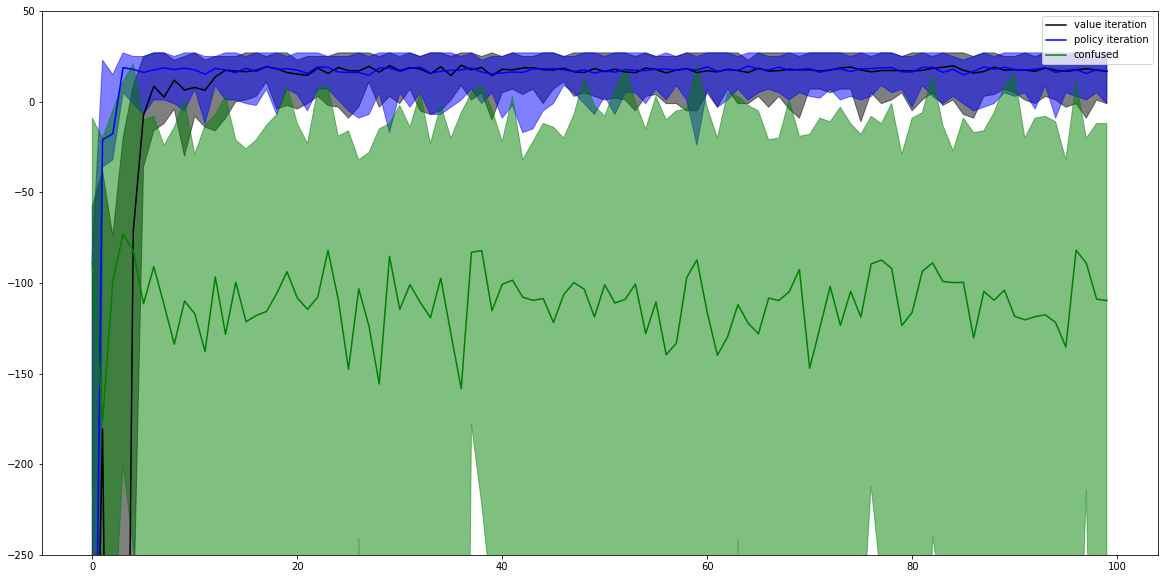

In [1842]:
plt.figure(figsize=(20, 10))
colors = ['k', 'b', 'g']
for i in range(3):
    plot_mean_and_CI(rewards_mean[i], rewards_max[i], rewards_min[i], colors[i], colors[i])
plt.ylim((-250, 50))
plt.legend(['value iteration', 'policy iteration', 'confused'])
plt.savefig('./q1_c_graph.png')
plt.show()

### Q1. c. ii. Value Iteration Visualization (Value function and policy plots)

#### Value function Plot

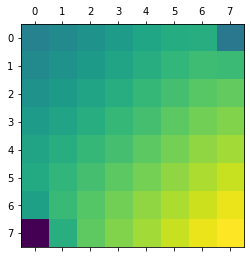

In [1843]:
size = np.sqrt(len(MDP1[0])).astype('int')
s = [[0 for _ in range(size)] for _ in range(size)]
for state, value in agents[0].V.items():
    if agents[0].is_term(state):
        s[state[0]][state[1]] = term_rewards[state]
    else:
        s[state[0]][state[1]] = value
plt.matshow(s)
plt.savefig('./q1_value_iter_value_func.png')
plt.show()

#### Policy plot

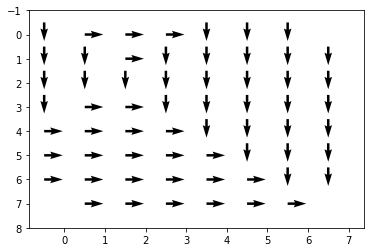

In [1856]:
size = np.sqrt(len(MDP1[0])).astype('int')
dx = []
dy = []#[0 for _ in range(len(MDP1[0]))]
s0 = []#[0 for _ in range(len(MDP1[0]))]
s1 = []#[0 for _ in range(len(MDP1[0]))]
for state, dir_ in agents[0].Policy.items():
    s0.append(state[0])
    s1.append(state[1])
    if agents[0].is_term(state):
        dx.append(0)
        dy.append(0)
    elif dir_ == 'd':
        dx.append(1)
        dy.append(0)
        s0[-1] -= 0.5
    elif dir_ == 'l':
        dx.append(-1)
        dy.append(0)
        s0[-1] -= 0.5
    elif dir_ == 'u':
        dx.append(0)
        dy.append(1)
        s1[-1] += 0.5
        s0[-1] -= 0.5
    elif dir_ == 'r':
        dx.append(0)
        dy.append(-1)
        s1[-1] -= 0.5
        s0[-1] -= 0.5
#s0 = np.array(s0)/1.1 + 0.001
#s1 = np.array(s1)/1.1 + 0.001
#plt.arrow(s0, s1, dx, dy)
#plt.xlim((0, 1))
for i in range(len(s0)):
    plt.quiver(s0[i], s1[i], dx[i], dy[i])
#plt.quiver([s0, s1], dx, dy)
plt.ylim((8, -1))
plt.show()

### Q1. c. ii. Policy Iteration Visualisation (Value function and policy plots)

#### Value function plot

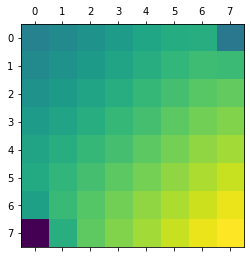

In [1819]:
size = np.sqrt(len(MDP1[0])).astype('int')
s = [[0 for _ in range(size)] for _ in range(size)]
for state, value in agents[1].V.items():
    if agents[0].is_term(state):
        s[state[0]][state[1]] = term_rewards[state]
    else:
        s[state[0]][state[1]] = value
plt.matshow(s)
plt.savefig('./q1_policy_iter_value_func.png')
plt.show()

#### Policy plot

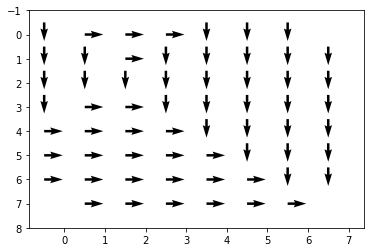

In [1852]:
size = np.sqrt(len(MDP1[0])).astype('int')
dx = []
dy = []#[0 for _ in range(len(MDP1[0]))]
s0 = []#[0 for _ in range(len(MDP1[0]))]
s1 = []#[0 for _ in range(len(MDP1[0]))]
for state, dir_ in agents[1].Policy.items():
    s0.append(state[0])
    s1.append(state[1])
    if agents[0].is_term(state):
        dx.append(0)
        dy.append(0)
    elif dir_ == 'd':
        dx.append(1)
        dy.append(0)
        s0[-1] -= 0.5
    elif dir_ == 'l':
        dx.append(-1)
        dy.append(0)
        s0[-1] -= 0.5
    elif dir_ == 'u':
        dx.append(0)
        dy.append(1)
        s1[-1] += 0.5
        s0[-1] -= 0.5
    elif dir_ == 'r':
        dx.append(0)
        dy.append(-1)
        s1[-1] -= 0.5
        s0[-1] -= 0.5
#s0 = np.array(s0)/1.1 + 0.001
#s1 = np.array(s1)/1.1 + 0.001
#plt.arrow(s0, s1, dx, dy)
#plt.xlim((0, 1))
for i in range(len(s0)):
    plt.quiver(s0[i], s1[i], dx[i], dy[i])
#plt.quiver([s0, s1], dx, dy)
plt.ylim((8, -1))
plt.show()

### Q1. c. iii. Change in gamma to change in policy comparision

γ = 0, 0.1, 0.5, 0.75, 1

* when gamma is very low, the agent tries to take an action which maximises its immediate reward, which is either -1 or positive terminal rewards. Notice how the agent avoids (0, 7) (reward = -10) when gamma = 0 but takes it when gamma = 0.1 and again starts avoiding it from gamma = 0.5.
* As gamma increases the agent tries to reach (7, 7) (reward = 40) from further and further states.

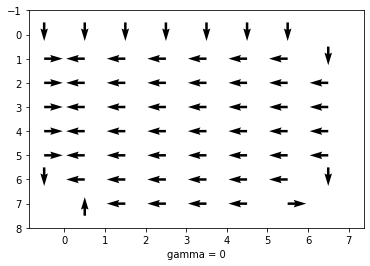

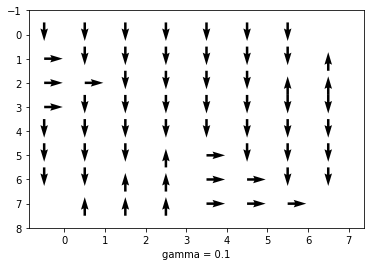

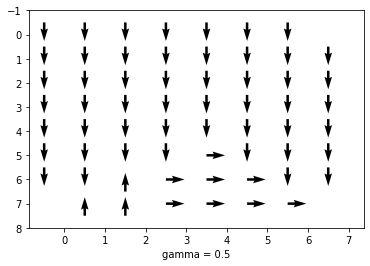

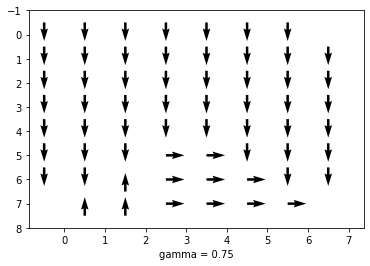

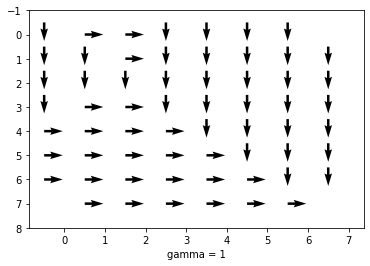

In [1858]:
for i, gamma in enumerate([0, 0.1, 0.5, 0.75, 1]):
    p = PolicyIteration(MDP1, theta=0.01, gamma=gamma)
    p.run(max_steps=1000)
    
    size = np.sqrt(len(MDP1[0])).astype('int')
    dx = []
    dy = []#[0 for _ in range(len(MDP1[0]))]
    s0 = []#[0 for _ in range(len(MDP1[0]))]
    s1 = []#[0 for _ in range(len(MDP1[0]))]
    for state, dir_ in p.Policy.items():
        s0.append(state[0])
        s1.append(state[1])
        if agents[0].is_term(state):
            dx.append(0)
            dy.append(0)
        elif dir_ == 'd':
            dx.append(1)
            dy.append(0)
            s0[-1] -= 0.5
        elif dir_ == 'l':
            dx.append(-1)
            dy.append(0)
            s0[-1] -= 0.5
        elif dir_ == 'u':
            dx.append(0)
            dy.append(1)
            s1[-1] += 0.5
            s0[-1] -= 0.5
        elif dir_ == 'r':
            dx.append(0)
            dy.append(-1)
            s1[-1] -= 0.5
            s0[-1] -= 0.5
    #s0 = np.array(s0)/1.1 + 0.001
    #s1 = np.array(s1)/1.1 + 0.001
    #plt.arrow(s0, s1, dx, dy)
    #plt.xlim((0, 1))
    for i in range(len(s0)):
        plt.quiver(s0[i], s1[i], dx[i], dy[i])
    #plt.quiver([s0, s1], dx, dy)
    plt.xlabel('gamma = ' + str(gamma))
    plt.ylim((8, -1))
    plt.show()

## Q2.a. Explanation:
$
Notations: \\
Requests\ in\ station\ i = rq_i \\
Returns\ in\ station\ i = rt_i \\
Poisson\ \dot{p}(l, m) = l^m/m! * e^{-m}\\
Gamma\ for\ requests\ in\ station\ i = grq_i \\
Gamma\ for\ returns\ in\ station\ i = grt_i \\ \\
$
$
MDP: \\
*\ States:\S = {(i, j) | 0 <= i <= 20, 0 <= j <= 20} \quad\quad\quad\quad\quad\quad\quad\quad\text{Each state is a tuple of cars in respective stations}\\
*\ Actions\ A = (-5, -4, ..., 4, 5) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{Cars to be moved from station 1 to station 2}\\
*\ Rewards\ R(s, a, s', rq_1, rt_1, rq_2, rt_2) = (rq_1 + rq_2) * 10 - a * 2\quad\quad  \text{if s >= rq_1 and s' >= rq_2} \\
\ \ \ Rewards\ R(s, a, s', rq_1, rt_1, rq_2, rt_2) = -1000\quad\quad\quad\quad\quad\quad\quad\quad  \text{if s < rq_1 and s' < rq_2} \\ \\
*\ \text{Transition probabilities can be computed from:}\quad \\
\ \ \ \quad P'(s, a, rq_1, rt_1, rq_2, rt_2) =  \dot{p}(grq_1, rq_1) * \dot{p}(grt_1, rt_1) * \dot{p}(grq_2, rq_2) * \dot{p}(grt_2, rt_2) \quad \\
\ \ \ \text{where s' can be computed as }  \\
\ \ \ \quad s' = (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \quad \text{provided s' is a valid state.} \\
*\ \text{Transition probabilities are then obtained by summing over all}\\
\quad  rq_1, rt_1, rq_2, rt_2 \ \text{which lead to a particular}\ s' \ \text{for given}\ s, a \\
\ \ \ \quad P(s, a, s') = \sum_{rq_1 = 1}^{rq_1=20}\sum_{rt_1 = 1}^{rt_1=20}\sum_{rq_2 = 1}^{rq_2=20}\sum_{rt_2 = 1}^{rqt_2=20} \left( s' == (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \right) * P'(s, a, rq_1, rt_1, rq_2, rt_2)\\
*\ \text{Similarly, rewards can also be calculated as:} \\
\ \ \ \quad R(s, a, s') = \sum_{rq_1 = 1}^{rq_1=20}\sum_{rt_1 = 1}^{rt_1=20}\sum_{rq_2 = 1}^{rq_2=20}\sum_{rt_2 = 1}^{rqt_2=20} \left( s' == (s[0] - rq_1 + rt_1 - a, s[1] - rq_2 + rt_2 + a) \right) * P'(s, a, rq_1, rt_1, rq_2, rt_2) * R(s, a, s', rq_1, rt_1, rq_2, rt_2)\\
$
$
Bellman\ update\ for\ policy\ iteration: \\
\text{For a given policy: } \pi \text{ and a given } \theta\\
\quad\text{Policy evaluation: }\\
\quad\quad\text{For each s in S:} \\
\quad\quad\quad v := V(s) \\
\quad\quad\quad V(s) := \sum_{s'}P(s, \pi(s), s') * [R(s, \pi(s), s') + \gamma * V(s')] \\
\quad\quad\quad \delta := max(\delta, | V - V(s) |)\\
\quad\quad until\ \delta < \theta \\
\quad\text{Policy update: }\\
\quad\quad\pi_{old} := \pi \\
\quad\quad\pi(s) := argmax_a \sum_{s'} P(s, a, s') * [R(s, a, s') + \gamma * V(s')] \\
\quad if\ \pi_{old} == \pi: return\ \pi \\
\quad else:\ do\ policy\ evaluation
$

## Q2. b. 

In [1734]:
p2 = PolicyIteration(MDP2)

### Generate first 5 policies and plot them for MDP2 (MDP without bonus):

In [1735]:
policies = []
for i in range(5):
    print(i, end=' ')
    p2.evaluate_policy()
    p2.update_policy()
    policies.append(copy.deepcopy(p2.Policy))

0 1 2 3 4 

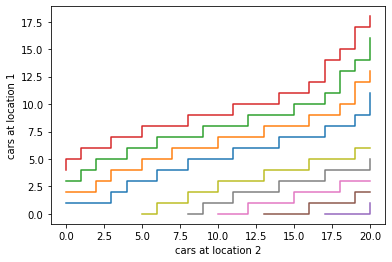

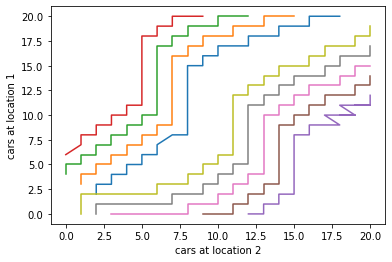

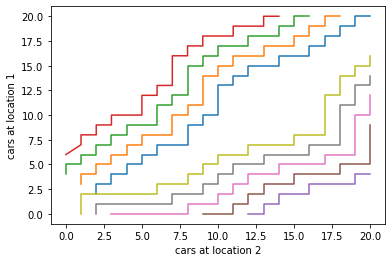

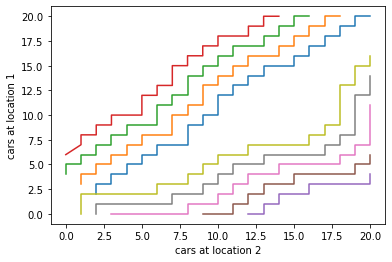

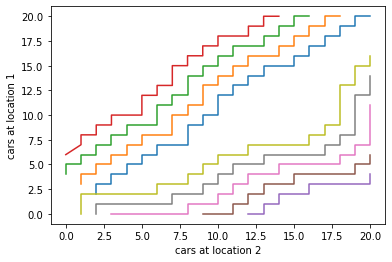

In [1736]:
for j in range(5):
    p = policies[j]
    g = [[] for _ in range(11)]
    for s, a in p.items():
        #if 0 not in s: # removing terminal states
        g[a].append(list(s))
    g = [sorted(i, key=lambda x: x[1] * 10 + x[0]) for i in g]
    g = [list(zip(*i)) for i in g]
    legends = []
    
    prev_y = 0
    for i in range(11):
        if not i == 0 and not i == 5:
            #try:

            g[i][0] = list(g[i][0])
            for k in range(1, len(g[i][0])):
                if g[i][0][k] < g[i][0][k-1]:
                    g[i][0][k] = g[i][0][k-1]   
            plt.plot(g[i][1], g[i][0])
            if i <= 5: legends.append(i)
            else: legends.append(i-11)
            #except Exception as e:
            #    print(e)
    #plt.legend(legends)
    plt.xlabel('cars at location 2')
    plt.ylabel('cars at location 1')
    plt.show()
    #plt.savefig('./q2_policy_' + str(j + 1) + '.png')
    #plt.clf()
    #plt.show()

## Q2. c bonus

In [1714]:
p2 = PolicyIteration(MDP2_bonus)

### Generate first 5 policies and plot them for MDP2 (MDP with bonus):

In [1715]:
policies = []
for i in range(5):
    print(i, end=' ')
    p2.evaluate_policy()
    p2.update_policy()
    policies.append(copy.deepcopy(p2.Policy))

0 1 2 3 4 

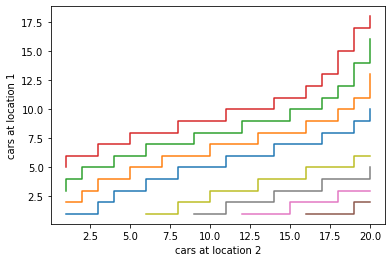

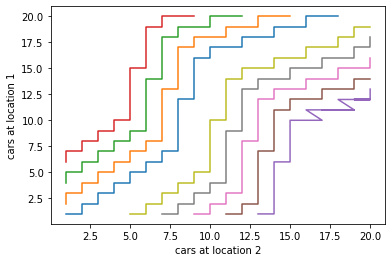

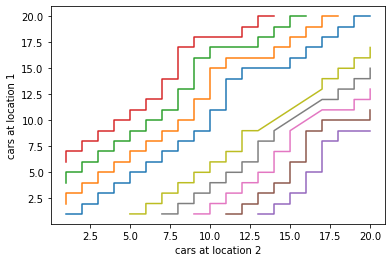

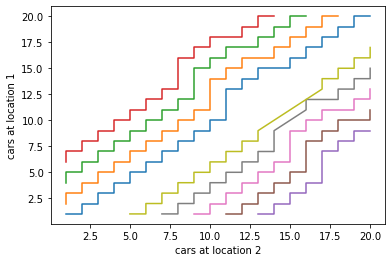

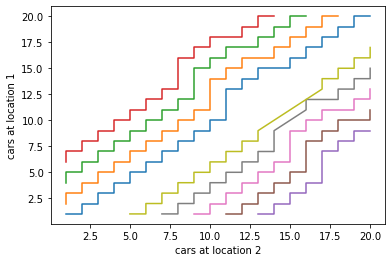

In [1732]:
for j in range(5):
    p = policies[j]
    g = [[] for _ in range(11)]
    for s, a in p.items():
        #if 0 not in s: # removing terminal states
        g[a].append(list(s))
    g = [sorted(i, key=lambda x: x[1] * 10 + x[0]) for i in g]
    g = [list(zip(*i)) for i in g]
    legends = []
    
    prev_y = 0
    for i in range(11):
        if not i == 0 and not i == 5:
            try:
                #print(i, end=' ')
                g[i][0] = list(g[i][0])
                for k in range(1, len(g[i][0])):
                    if g[i][0][k] < g[i][0][k-1]:
                        g[i][0][k] = g[i][0][k-1]   
                plt.plot(g[i][1], g[i][0])
                if i <= 5: legends.append(i)
                else: legends.append(i-11)
            except: pass
            #except Exception as e:
            #    print(e)
    #plt.legend(legends)
    #plt.show()
    #plt.savefig('./q2_bonus_policy_' + str(j + 1) + '.png')
    #plt.clf()
    plt.xlabel('cars at location 2')
    plt.ylabel('cars at location 1')
    plt.show()

## Q2.c: Final policy for MDP2 (MDP with bonus)

In [1721]:
p2.run(max_steps=np.inf)

1

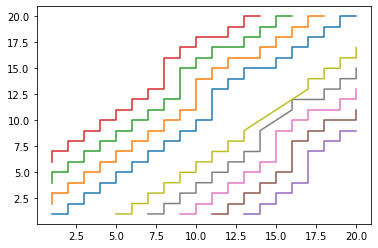

In [1722]:
p = p2.Policy
g = [[] for _ in range(11)]
for s, a in p.items():
    #if 0 not in s: # removing terminal states
    g[a].append(list(s))
g = [sorted(i, key=lambda x: x[1] * 10 + x[0]) for i in g]
g = [list(zip(*i)) for i in g]
legends = []

prev_y = 0
for i in range(11):
    if not i == 0 and not i == 5:
        #try:

        g[i][0] = list(g[i][0])
        for k in range(1, len(g[i][0])):
            if g[i][0][k] < g[i][0][k-1]:
                g[i][0][k] = g[i][0][k-1]   
        plt.plot(g[i][1], g[i][0])
        if i <= 5: legends.append(i)
        else: legends.append(i-11)
        #except Exception as e:
        #    print(e)
#plt.legend(legends)
#plt.show()
plt.savefig('./q2_bonus_final_policy.png')
#plt.clf()

## Q3.a. Explanation
$
Notations:\\
p:\ \text{The probability with which heads shows}\quad\quad\quad\quad\quad\quad\\
$
$
MDP: \\
*\ States:\S = {i | 0 <= i <= 100} \quad\quad\quad\quad\quad\quad\quad\quad\text{Each state is a tuple of cars in respective stations}\\
*\ Actions\ A = (1, 2, ..., min(s, 100-s)) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{Where s is the state}\\
*\ Transition\ probability\ P(s, a, s') = p \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{if s' > s}\\
\ \ \ Transition\ probability\ P(s, a, s') = 1-p \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{if s' < s}\\
*\ Rewards\ R(s, a, s') = 1\quad\quad \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{if s' == 100}\\
\ \ \ Rewards\ R(s, a, s') = 0\quad\quad \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\text{if not s' == 100}\\ \\
$
$
Bellman\ update\ for\ Value\ iteration\ for\ given\ \theta: \\
V_{old} := V \\
\delta = -infinity \\
for\ each\ state\ s:\\
\quad V(s) := argmax_a \sum_{s'} P(s, a, s') * [R(s, a, s') + \gamma * V_{old}(s')]\\
\quad \delta := max(\delta, | V_{old}(s) - V(s) |)\\
until\ \delta < \theta \\
$

## Q3.b. Plots

#### P = 0.3

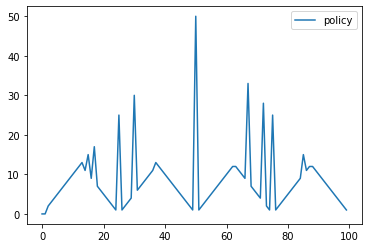

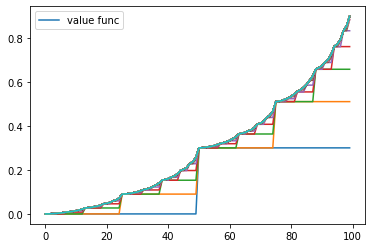

In [1728]:
v3 = ValueIteration(MDP3_03, theta=0, gamma=1.0)
v3.run()
plt.plot(list(v3.Policy.values())[:-1])
plt.savefig('./q3_policy_03.png')
plt.legend(['policy'])
plt.show()
v3 = ValueIteration(MDP3_03, theta=0, gamma=1.0)
for i in range(100):
    v3.run(max_steps=1)
    plt.plot(list(v3.V.values())[:-1])
    plt.legend(['value func'])
plt.savefig('./q3_value_func_03.png')
plt.show()

#### P = 0.15

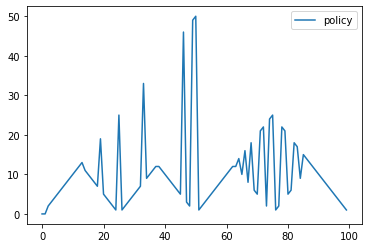

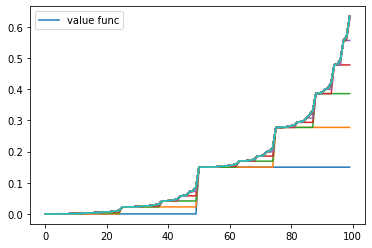

In [1729]:
v3 = ValueIteration(MDP3_15, theta=0, gamma=1.0)
v3.run()
plt.plot(list(v3.Policy.values())[:-1])
plt.savefig('./q3_policy_015.png')
plt.legend(['policy'])
plt.show()
v3 = ValueIteration(MDP3_15, theta=0, gamma=1.0)
for i in range(100):
    v3.run(max_steps=1)
    plt.plot(list(v3.V.values())[:-1])
    plt.legend(['value func'])
plt.savefig('./q3_value_func_015.png')
plt.show()

#### P = 0.65

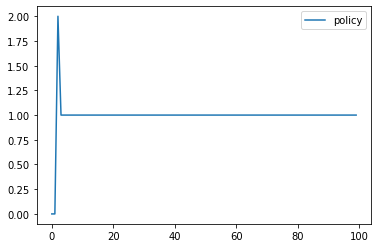

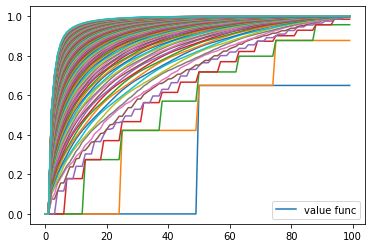

In [1731]:
v3 = ValueIteration(MDP3_65, theta=0, gamma=1.0)
v3.run()
plt.plot(list(v3.Policy.values())[:-1])
plt.savefig('./q3_policy_065.png')
plt.legend(['policy'])
plt.show()
v3 = ValueIteration(MDP3_65, theta=0, gamma=1.0)
for i in range(100):
    v3.run(max_steps=1)
    plt.plot(list(v3.V.values())[:-1])
    plt.legend(['value func'])
plt.savefig('./q3_value_func_065.png')
plt.show()

## Q3.c Theta convergence

* Let's consider theta to be in `[0.1, 0.01, 0.001, 0.0001, 0.00001..., 10^-10]`
* As we can see, while there is little difference in value functions, the policy changes significantly, but the results stabilized as theta gets smaller and smaller

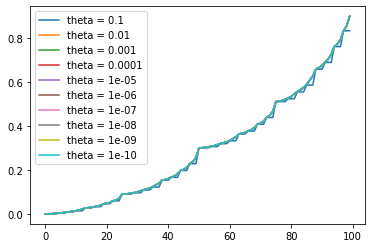

In [1706]:
legends = []
for i in range(10):
    theta=1/np.power(10, i+1)
    v3 = ValueIteration(MDP3_03, theta=theta, gamma=1.0)
    v3.run()
    plt.plot(list(v3.V.values())[:-1])
    legends.append('theta = ' + str(theta))
    #plt.savefig('./q3_value_func.png')
plt.legend(legends)    
plt.savefig('./q3_value_func_convergence.png')

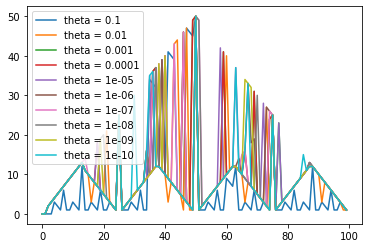

In [1707]:
for i in range(10):
    theta=1/np.power(10, i+1)
    v3 = ValueIteration(MDP3_03, theta=theta, gamma=1.0)
    v3.run()
    plt.plot(list(v3.Policy.values())[:-1])
    legends.append('theta = ' + str(theta))
    #plt.savefig('./q3_value_func.png')
plt.legend(legends) 
plt.savefig('./q3_policy_convergence.png')